# Segmentation Network Example

Builds a unet segmentation neural network with TensorFlow 2.0 eager execution ([code](../examples/color/segmentation.py))

### Code Overview:
1. Import libraries
2. Import data for training and testing 
3. Define Model
4. Define Loss function
5. Define Training procedure
6. Run Model code 
    a. Train model
    b. Test model
7. Plot accuracy of results

## Example Code

import libraries

In [1]:
from __future__ import absolute_import, division, print_function
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate
import matplotlib
import matplotlib.pyplot as plt

Define DataGenerator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cairo

WIDTH = 128
HEIGHT = 128
CHANNELS = 3

class DataGenerator:

    def __init__(self):
        self.size = 1000
        self.ratio = 0.8
        self.threshold = [128, 0, 0]

        self.WIDTH = WIDTH
        self.HEIGHT = HEIGHT
        self.CHANNELS = CHANNELS

        self.generate();

    def generate_image(self):
        ''' Randomly generates an image with random boxes '''    

        data = np.zeros( (HEIGHT,WIDTH, 4), dtype=np.uint8 ) 
        surface = cairo.ImageSurface.create_for_data( data, cairo.FORMAT_ARGB32, WIDTH, HEIGHT )
        ctx = cairo.Context( surface )

        ctx.scale (WIDTH, HEIGHT) # Normalizing the canvas
        ctx.set_source_rgb(0, 0, 0)
        ctx.rectangle (0, 0, 1, 1)  # Rectangle(x0, y0, x1, y1) 
        ctx.fill()

        # Create random colored boxes
        for _ in range(50):
            rc = np.random.rand(3)
            ctx.set_source_rgb(rc[0], rc[1], rc[2])

            r = np.random.rand(2)
            ctx.translate (r[0], r[1])      # Changing the current transformation matrix
            ctx.rectangle (0, 0, 0.1, 0.1)  # Rectangle(x0, y0, x1, y1)
            ctx.fill()
            ctx.translate (-r[0], -r[1])    # Changing the current transformation matrix

        # Create a randomly placed red box
        ctx.set_source_rgb(0, 0, 1)
        r = np.random.rand(2)
        ctx.translate (r[0], r[1])      # Changing the current transformation matrix
        ctx.rectangle (0, 0, 0.1, 0.1)  # Rectangle(x0, y0, x1, y1)
        ctx.fill()
        ctx.translate (-r[0], -r[1])

        img = data[:,:,0:3]
        return img;

    def whiten_data(self, features):
        """ whiten dataset - zero mean and unit standard deviation """
        features = np.reshape(features, (self.size, WIDTH * HEIGHT * CHANNELS))
        features = (np.swapaxes(features,0,1) - np.mean(features, axis=1)) / np.std(features, axis=1)
        features = np.swapaxes(features,0,1)
        features = np.reshape(features, (self.size, WIDTH, HEIGHT, CHANNELS))
        #features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
        return features

    def unwhiten_img(self, img): 
        """ remove whitening for a single image """ 
        img = np.reshape(img, (WIDTH * HEIGHT * CHANNELS))
        img = (img - np.min(img)) / (np.max(img) - np.min(img)) 
        img = np.reshape(img, (WIDTH, HEIGHT, CHANNELS))
        return img

    def generate(self):
        ''' Generates a randomly generated dataset '''
        img = self.generate_image()
        self.data = np.stack( (img, self.generate_image()))
        for _ in range(self.size - 2):
            img = self.generate_image()
            self.data = np.concatenate( (self.data, img[None,:]), axis=0)
        
        # Generate truth data
        self.label = np.all(np.greater_equal(self.data, self.threshold), axis=3) * 1.0;
        self.label = np.reshape(self.label, (self.size, WIDTH, HEIGHT, 1))
        self.label = np.concatenate( (1 - self.label, self.label), axis=3) # Index 0: Incorrect, Index 1: Correct

        # Setup data 
        self.data = self.whiten_data(self.data)

        # Split data into test/training sets
        index = int(self.ratio * len(self.data)) # Split index
        self.x_train = self.data[0:index, :].astype(np.float32)
        self.y_train = self.label[0:index].astype(np.float32)
        self.x_test = self.data[index:,:].astype(np.float32)
        self.y_test = self.label[index:].astype(np.float32)
    
        # Data lengths
        self.train_length = self.x_train.shape[0]
        self.test_length = self.x_test.shape[0]

    def show(self, index):
        ''' Show a data slice at index'''
        img = self.unwhiten_img( self.data[index] )
        plt.imshow(img)
        plt.show()

    def show_label(self, index):
        ''' Show a truth data slice at index'''
        img = self.label[index]
        plt.imshow(img[:,:,0], cmap='gray')
        plt.show()  
        plt.imshow(img[:,:,1], cmap='gray')
        plt.show()  

    def print(self):
        print("Data Split: ", self.ratio)
        print("Train => x:", self.x_train.shape, " y:", self.y_train.shape)
        print("Test  => x:", self.x_test.shape, " y:", self.y_test.shape)

    def next_batch(self, batch_size):
        ''' Retrieves the next batch for a given batch size '''
        length = self.x_train.shape[0]
        indices = np.random.randint(0, length, batch_size) # Grab batch_size values randomly
        return [self.x_train[indices], self.y_train[indices]]

    def batch_count(self, batch_size):
        return math.floor(self.train_length / batch_size)


Generate Dataset

In [3]:
# Generate Dataset
data = DataGenerator()
data.print()

Data Split:  0.8
Train => x: (800, 128, 128, 3)  y: (800, 128, 128, 2)
Test  => x: (200, 128, 128, 3)  y: (200, 128, 128, 2)


Set Training and Network Parameters

In [4]:
# Training Parameters
num_epochs = 10
display_step = 1
batch_size = 16

# Network Parameters
WIDTH = data.WIDTH; HEIGHT = data.HEIGHT; CHANNELS = data.CHANNELS
NUM_INPUTS = WIDTH * HEIGHT * CHANNELS
NUM_OUTPUTS = 2

Define Model

In [5]:
# Unet Model Architecture
def Model():

    def down_block(x, filters):
        x = Conv2D(filters, (3, 3), padding="same", activation=tf.nn.relu, kernel_initializer='he_normal')(x)
        x = Conv2D(filters, (3, 3), padding="same", activation=tf.nn.relu, kernel_initializer='he_normal')(x)
        x = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = Dropout(rate=0.0)(x)
        return x

    def max_pool(x):
        return MaxPooling2D(padding="same", strides=(2, 2), pool_size=(2, 2))(x)

    def up_block(x, filters, skip_connect):
        x = Conv2DTranspose(filters, (3, 3), strides=2, padding="same", activation=tf.nn.relu)(x)
        x = concatenate([x, skip_connect], axis=3)
        x = Conv2D(filters, (3, 3), padding="same", activation=tf.nn.relu, kernel_initializer='he_normal')(x)
        x = Conv2D(filters, (3, 3), padding="same", activation=tf.nn.relu, kernel_initializer='he_normal')(x)
        x = BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = Dropout(rate=0.0)(x)
        return x 

    def unet():
        fn = [32, 64, 128, 256, 512]
        fdepth = len(fn)

        x_stack = []
        xin = keras.Input(shape=(HEIGHT, WIDTH, CHANNELS), name='img')

        x = xin
        for idx in range(fdepth):
            x = down_block(x, fn[idx])

            if(idx < fdepth - 1):
                x_stack.append(x)
                x = max_pool(x)

        for idx in range(fdepth - 1):
            idx = fdepth - idx - 2
            x = up_block(x, fn[idx], x_stack.pop())

        xout = Conv2D(NUM_OUTPUTS, (1, 1), padding="same", activation=tf.nn.softmax)(x)
        return tf.keras.Model(inputs=xin, outputs=xout)

    return unet()

Define Train

In [6]:
@tf.function
def train(model, inputs, outputs):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss_value = loss(predictions, outputs)
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    train_loss(loss_value)

Define Test

In [7]:
@tf.function
def test(model, inputs, outputs):
    predictions = model(inputs)
    test_accuracy(outputs, predictions)

Set Losses and Optimizers 

In [8]:
# Setup Unet model
model = Model()
model.summary()

# Set Losses and Optimizers 
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

Train model

In [9]:
epochs = range(num_epochs)
for epoch in epochs:

    for _ in range(data.batch_count(batch_size)):
        x_train, y_train = data.next_batch(batch_size)
        train(model, x_train, y_train)
        test(model, data.x_test, data.y_test)
    
    if(epoch % display_step == 0):
        print('Epoch %2d: training loss=%2.5f test accuracy=%2.5f' % 
            (epoch, train_loss.result(), test_accuracy.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    test_accuracy.reset_states()

Epoch  0: training loss=1.75705 test accuracy=0.91617
Epoch  1: training loss=0.35460 test accuracy=0.98287
Epoch  2: training loss=0.23441 test accuracy=0.98769
Epoch  3: training loss=0.22768 test accuracy=0.98708
Epoch  4: training loss=0.18005 test accuracy=0.98906
Epoch  5: training loss=0.17037 test accuracy=0.98868
Epoch  6: training loss=0.16304 test accuracy=0.98892
Epoch  7: training loss=0.14469 test accuracy=0.99070
Epoch  8: training loss=0.14379 test accuracy=0.99158
Epoch  9: training loss=0.13169 test accuracy=0.99156


Plot Results

In [10]:
predictions = model(data.x_test)

index = 0
input_data = data.unwhiten_img(data.x_test[index])
truth_data = data.y_test[index][:,:,1] 
segmentation = np.greater(predictions[index,:,:,1], predictions[index,:,:,0]) * 1.0

Show Original Image

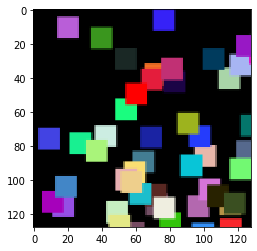

In [11]:
plt.imshow(input_data)

Show Truth Data

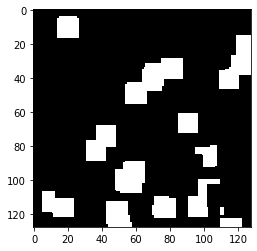

In [12]:
plt.imshow(truth_data, cmap='gray')

Show Prediction Results 

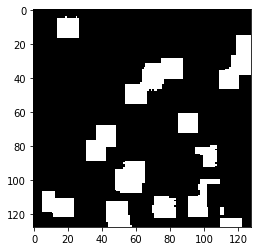

In [14]:
plt.imshow(segmentation, cmap='gray')